#### Using WIN@ (proportional adjust on maturity) of historical data of future contracts of b3 (Bovespa) Mini-índice

Tested with WIN@N (without adjust on maturity) and WIN@D (adjust by differences on maturity) where adjust of contracts are different the results are pretty similar. 

Downloaded as .csv using Metatrader 5 because binary bars downloaded did not include pre and after market data

In [1]:
%matplotlib inline

In [2]:
pwd

'D:\\Users\\andre.ferreira\\Documents\\stocks\\prototypes'

In [3]:
cd ..

D:\Users\andre.ferreira\Documents\stocks


In [4]:
%matplotlib inline

In [5]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import meta5Ibov
from algos.nn import torchNN, torchCV, torchUtil
import torch as th
import scipy
import talib as ta

In [6]:
cd data

D:\Users\andre.ferreira\Documents\stocks\data


In [7]:
pwd

'D:\\Users\\andre.ferreira\\Documents\\stocks\\data'

In [8]:
win = pd.read_csv('WIN@_M5_201406130900_201906131750.csv', delimiter='\t',
                 na_values=['null', '0'], 
                names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TickVol', 'Volume', 'Spread'],
                header=0)

In [9]:
win.tail()

,Date,Time,Open,High,Low,Close,TickVol,Volume,Spread
132840,2019.06.13,17:30:00,99675,99780,99675,99770,5697.0,25545,1
132841,2019.06.13,17:35:00,99765,99770,99685,99715,3514.0,13713,1
132842,2019.06.13,17:40:00,99710,99890,99705,99765,9243.0,32111,1
132843,2019.06.13,17:45:00,99760,99855,99725,99790,5038.0,18911,1
132844,2019.06.13,17:50:00,99795,100015,99735,100015,3155.0,17204,1


In [10]:
#win = win[94000:] # since 2018

In [11]:
# for yahooo finance data
#dow['Close'] = dow['Adj Close']  
win.drop(['TickVol', 'Spread'], axis=1, inplace=True) # Close is better than Adjusted Close
# 1/3%

In [12]:
win.isnull().sum().sum() # total number of cells with nans 

0

In [13]:
win.dropna(inplace=True)

Convert to datetime Date

In [14]:
win.Date = pd.to_datetime(win.Date+' '+win.Time)

In [15]:
win.head(2)

,Date,Time,Open,High,Low,Close,Volume
0,2014-06-13 09:00:00,09:00:00,84737,84891,84590,84628,1983
1,2014-06-13 09:05:00,09:05:00,84636,84690,84582,84667,1276


In [16]:
win.set_index(win.Date, drop=True, inplace=True);

In [17]:
win.drop(['Date', 'Time'], axis=1, inplace=True)

In [18]:
win['time'] = win.index.map(lambda x: x.time())
win['date'] = win.index.map(lambda x: x.date())

In [19]:
win['hour'] = win.time.apply(lambda x: x.hour)
win['minute'] = win.time.apply(lambda x: x.minute)
win['wday'] = win.date.apply(lambda x: x.weekday()) # week day where Monday is 0 and Sunday is 6
# friday is 4

In [20]:
win.head()

,Open,High,Low,Close,Volume,time,date,hour,minute,wday
Date,,,,,,,,,,
2014-06-13 09:00:00,84737,84891,84590,84628,1983,09:00:00,2014-06-13,9,0,4
2014-06-13 09:05:00,84636,84690,84582,84667,1276,09:05:00,2014-06-13,9,5,4
2014-06-13 09:10:00,84667,84760,84651,84690,1019,09:10:00,2014-06-13,9,10,4
2014-06-13 09:15:00,84675,84706,84659,84675,328,09:15:00,2014-06-13,9,15,4
2014-06-13 09:20:00,84675,84706,84667,84675,297,09:20:00,2014-06-13,9,20,4


 ### Total number of days

In [21]:
len(win.groupby(win.date)) # days

1236

### We can see the data  market hours were correct from summer time

 - ignoring some outliers
 - pre-market is from 9:00 to 10:00 
 - after-market is from 17:00 to 18:00/18:15    

D:\Users\andre.ferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


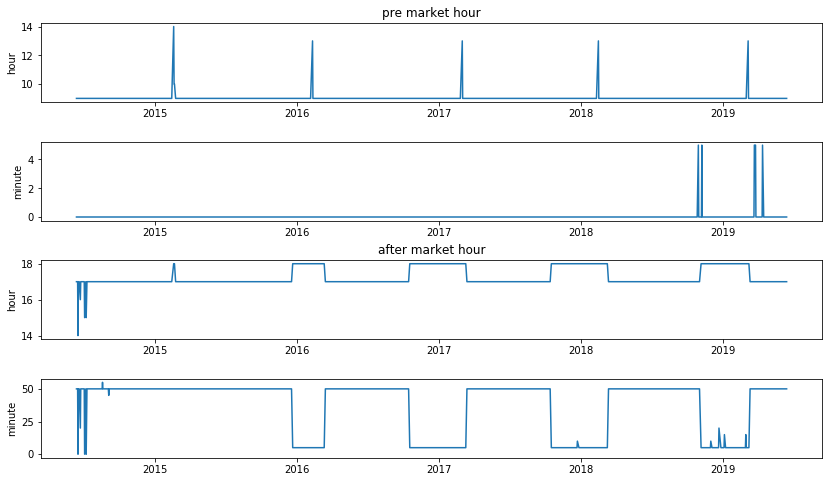

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(14,8))

ax1.plot(win.groupby(win.date).time.agg(['min']).applymap(lambda x: x.hour))
ax1.set_ylabel('hour')
ax1.set_title('pre market hour')

ax2.plot(win.groupby(win.date).time.agg(['min']).applymap(lambda x: x.minute))
ax2.set_ylabel('minute')


ax3.plot(win.groupby(win.date).time.agg(['max']).applymap(lambda x: x.hour))
ax3.set_ylabel('hour')
ax3.set_title('after market hour')

ax4.plot(win.groupby(win.date).time.agg(['max']).applymap(lambda x: x.minute))
ax4.set_ylabel('minute')

plt.subplots_adjust(hspace=0.5)

### First let's look of days of gaps

 - everyday has a gap

In [23]:
windays = win.groupby(win.date)

In [24]:
windays['Close'].agg(['last']).head(3)
#windays['Open'].agg(['first']).head(3)

,last
date,
2014-06-13,84953
2014-06-16,84706
2014-06-17,83832


- Everyday that was not preceeded by its correct week day doesnt have a valid gap or 
- was a holiday 

Since they are few and we have the holidays we  
we will just ignore any incorrect gap

In [25]:
weekfails = np.diff(windays.wday.agg('first'))

In [26]:
weekfails[ (weekfails != -4) & (weekfails != 1) ]

array([ 2,  2,  2,  3,  3, -2, -3,  2, -3,  2,  2, -3, -3, -3, -3, -2, -2,
       -3, -2, -3,  2,  2,  2,  2,  2,  2, -3,  2, -2, -3, -3, -3,  2,  2,
        2,  2,  2, -3, -3, -2,  2, -2, -3,  2,  2, -3, -3, -3, -3,  2,  2,
       -2, -2, -3, -2, -3,  2], dtype=int64)

In [27]:
np.count_nonzero(weekfails[ (weekfails != -4) & (weekfails != 1) ])

57

In [28]:
np.count_nonzero(weekfails[ (weekfails != -4) & (weekfails != 1) ])/len(weekfails)

0.046153846153846156

Invalid gaps will certainly be smaller than 4% due holidays

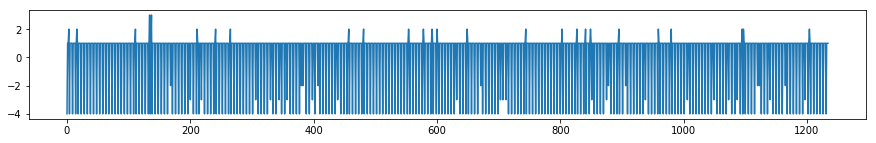

In [29]:
plt.figure(figsize=(15,2))
plt.plot(weekfails)

- Everyday where data started after 9:00 cannot have a valida gap
- Everyday where the day before did not end after 17 hours cannot have a valid gap

In [30]:
hourfails = windays.hour.agg('first').values

In [31]:
hourfails[hourfails != 9]

array([14, 10, 10, 13, 13, 13, 13], dtype=int64)

In [32]:
hourfails = windays.hour.agg('last').values

In [33]:
hourfails[hourfails < 17]

array([14, 16, 15, 15], dtype=int64)

- We will ignore for now they seam few

In [34]:
# tomorrow day - today's close
# dont have gap on first day that's why [:1] / [:-1]
pclose = windays['Close'].agg(['last']).values[:-1] # previous close
dayopen = windays['Open'].agg(['first']).values[1:]  
gaps = dayopen-pclose

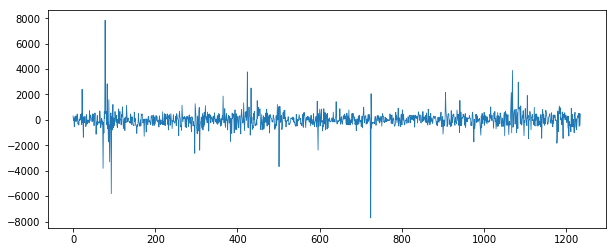

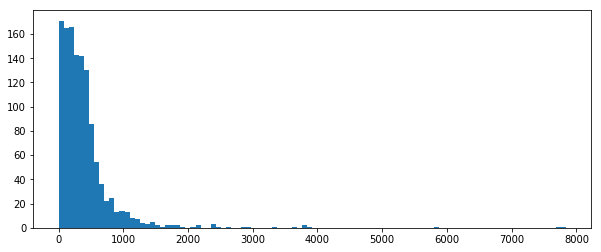

In [35]:
plt.figure(figsize=(10,4))
plt.plot(gaps, lw=0.8)
plt.figure(figsize=(10,4))
plt.hist(abs(gaps), bins=100);

In [36]:
len(gaps[gaps > 0])/len(gaps)

0.5020242914979757

In [37]:
np.percentile(abs(gaps), [90])

array([773.])

In [38]:
np.percentile(abs(gaps), [10])

array([56.])

 ### Some conclusions
 
 - 90% of day gaps are smaller than ~700 points
 - 90% of days have gaps bigger than ~56 points
 - 50.2% up gaps and 49.8% of down gaps fairly even

## How many gaps close ?

 - Considering even aftermarket hour (query 'hour >= 17')

In [39]:
daymin = windays['High', 'Low'].agg(['min', 'max']).min(axis=1)[1:] # first day cannot have gap
daymax = windays['High', 'Low'].agg(['min', 'max']).max(axis=1)[1:]
dayshl = np.stack((daymin, daymax), axis=-1)
dayshl[-5:]

array([[ 98132,  99394],
       [ 97718,  98849],
       [ 98637, 100050],
       [ 98810, 100290],
       [ 99465, 100420]], dtype=int64)

Variation in points H and L after dayning

In [40]:
varhl = dayshl-dayopen

In [41]:
varhl[-5:]

array([[-187, 1075],
       [-702,  429],
       [   0, 1413],
       [-790,  690],
       [-485,  470]], dtype=int64)

In [42]:
gaps[-5:]

array([[ 510],
       [-525],
       [ 495],
       [-450],
       [ 460]], dtype=int64)

In [43]:
gapsign = np.sign(gaps).ravel()
select = gapsign-1
select[select < 0] = 1
select = select.ravel()
select

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

Difference between the gap value in points due to an up or down to the corresponding low and high of the day.

In [44]:
gapdif = gaps.ravel() + varhl[np.arange(len(varhl)), select]
gapdif[-5:]

array([323, -96, 495, 240, -25], dtype=int64)

Gap sign

 - 1 means up gap 
 - -1 means down gap

In [45]:
gapsign[-5:]

array([ 1, -1,  1, -1,  1], dtype=int64)

Gap results 

  * bigger >= 0 means the gap was closed and even went further that many points
  * smaller < 0 means the gap was not closed and that many points were the distance missing to close

In [46]:
gapresult = gapdif*gapsign*-1

In [47]:
gapresult[-5:]

array([-323,  -96, -495,  240,   25], dtype=int64)

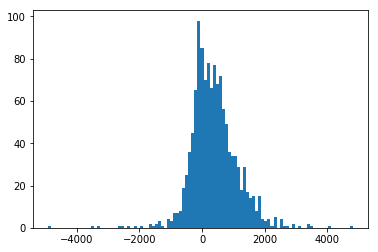

In [48]:
plt.hist(gapresult, bins=100);

In [49]:
len(gapresult[gapresult >=0 ])/len(gapresult)

0.6987854251012146

In [50]:
iselected = np.argwhere( (abs(gaps.ravel()) < 230) )
selectedgapresult = gapresult[iselected]
len(selectedgapresult[selectedgapresult >=0 ])/len(selectedgapresult)

0.9024390243902439

In [51]:
iselected = np.argwhere( abs(gaps.ravel()) > 2400)
selectedgapresult = gapresult[iselected]
1.-(len(selectedgapresult[selectedgapresult >= 0 ])/len(selectedgapresult))

0.9230769230769231

In [52]:
len(gapresult[gapresult >= -100 ])/len(gapresult)

0.7692307692307693

## Some conclusions
 
 - roughly 70% of gaps close
 - gaps with less than 230 points 90% times close!!
 - gaps with more than 2500 points 90% times never close!!

## A classifier with Random Forest

Gap will close or not? 

### Better accuracy than 70%?

- day before above or bellow the moving average of 21D on Close
- day before above or bellow the moving average of 200D on Close
- day before after-market O-H-L-C
- gap-day day price
- gap size and signal
- future use vwap 

In [53]:
dfgaps = pd.DataFrame()

In [54]:
pdaymin = windays['High', 'Low'].agg(['min', 'max']).min(axis=1)[:-1] # previous day high and low
pdaymax = windays['High', 'Low'].agg(['min', 'max']).max(axis=1)[:-1]
#pdayshl = np.stack((daymin, daymax), axis=-1)

In [55]:
dfgaps['gap'] = gaps.flatten()
dfgaps['result'] = gapresult
dfgaps['sign'] = gapsign
dfgaps['date'] = windays.date.first().values[1:]
dfgaps['wday'] = windays.wday.first().values[1:] # day of the gap
dfgaps['wdayp'] = windays.wday.first().values[:-1] # day before the gap
dfgaps.loc[:, 'phdif'] = pdaymax.values.flatten()-dayopen.flatten()
dfgaps.loc[:, 'pldif'] = pdaymin.values.flatten()-dayopen.flatten()
dfgaps['phdif'] = dfgaps['phdif']*dfgaps['sign']*-1 # difference of open to high of previous day gap sign corrected
dfgaps['pldif'] = dfgaps['pldif']*dfgaps['sign']*-1 # difference of open to low of previous day gap sign corrected
dfgaps['dayopen'] = dayopen

In [56]:
dfgaps.head(4)

,gap,result,sign,date,wday,wdayp,phdif,pldif,dayopen
0,302,657,1,2014-06-16,0,4,-30,727,85255
1,-47,247,-1,2014-06-17,1,0,650,-363,84659
2,145,282,1,2014-06-18,2,1,-976,277,83977
3,-541,-442,-1,2014-06-20,4,2,541,-1356,84906


In [57]:
pwd

'D:\\Users\\andre.ferreira\\Documents\\stocks\\data'

Should replace this by mt5 ibov daily 

In [58]:
ibv = pd.read_csv('bovespa_1993_daily.csv', delimiter=',',
                 na_values=['null', '0'])
ibv.drop(['Adj Close'] , axis=1, inplace=True) # Close is better than Adjusted Close

In [59]:
ibv.isnull().sum().sum() # total number of cells with nans in the beggining
ibv.dropna(inplace=True)

In [60]:
ibv.Volume = np.log(ibv.Volume+100) # correction for volume
ibv.head(1)

,Date,Open,High,Low,Close,Volume
2395,2002-07-02,10891.0,10908.0,10711.0,10846.0,18.400544


In [61]:
ibv.Date = pd.to_datetime(ibv.Date)
ibv.set_index(ibv.Date, drop=True, inplace=True);
ibv.index = ibv.index.date # remove useless time part of index
ibv.drop(['Date'], axis=1, inplace=True)
ibv['MA21DC'] = ta.MA(ibv.Close, 21) # month trend
ibv['MA200DC'] = ta.MA(ibv.Close, 200) # yearly trend
ibv['MA5DVL'] = ta.MA(ibv.Volume, 5) # average volume last week
ibv['MA21DVL'] = ta.MA(ibv.Volume, 21) # average volume last week
ibv['STD5DHL'] = ta.STDDEV(ibv.High-ibv.Low, 5) # average volatility on H-L  last week
ibv['STD21DHL'] = ta.STDDEV(ibv.High-ibv.Low, 21) # average volatility on H-L last month
ibv.dropna(inplace=True) # nans from MAs

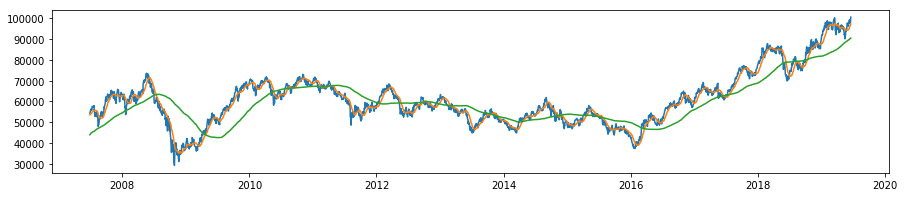

In [62]:
plt.figure(figsize=(15,3))
plt.plot(ibv.index, ibv.Close)
plt.plot(ibv.index, ibv['MA21DC']) # 21D MA
plt.plot(ibv.index, ibv['MA200DC']) #200D MA

In [63]:
ibv["up200"] = 0
ibv.loc[ibv.Close > ibv.MA200DC, "up200"] = 1 
ibv["up21"] = 0
ibv.loc[ibv.Close > ibv.MA21DC, "up21"] = 1 
ibv['upvl5d'] = 0
ibv.loc[ibv.Volume > ibv.MA5DVL, "upvl5d"] = 1 
ibv['upvl21d'] = 0
ibv.loc[ibv.Volume > ibv.MA5DVL, "upvl21d"] = 1 
ibv['upstd5dhl'] = 0
ibv.loc[(ibv.High-ibv.Low) > ibv.STD5DHL, "upstd5dhl"] = 1 
ibv['upstd21dhl'] = 0
ibv.loc[(ibv.High-ibv.Low) > ibv.STD21DHL, "upstd21dhl"] = 1 
ibv['ibvclose'] = ibv.Close[:-1] # previous day index close

In [64]:
ibv.head(2)

,Open,High,Low,Close,Volume,MA21DC,MA200DC,MA5DVL,MA21DVL,STD5DHL,STD21DHL,up200,up21,upvl5d,upvl21d,upstd5dhl,upstd21dhl,ibvclose
2007-06-29,54150.0,54783.0,53958.0,54392.0,18.262811,53579.904762,44070.940,18.227992,18.410183,202.353552,303.209484,1,1,1,1,1,1,54392.0
2007-07-02,54396.0,55386.0,54396.0,55371.0,18.023539,53727.666667,44293.565,18.181750,18.380582,200.125361,302.719915,1,1,0,0,1,1,55371.0


In [65]:
dfgaps = dfgaps.join(ibv[['ibvclose', 'up200', 'up21', 'upvl5d', 'upvl21d', 'upstd5dhl', 'upstd21dhl']], on='date')

In [66]:
dfgaps.isnull().sum().sum() # just to make sure all days got it
dfgaps.dropna(inplace=True)

In [67]:
from scipy.signal import detrend

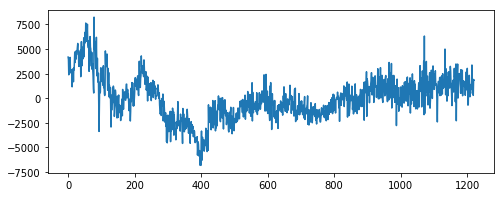

In [68]:
plt.figure(figsize=(8,3))
plt.plot(detrend(dfgaps.dayopen - dfgaps.ibvclose))

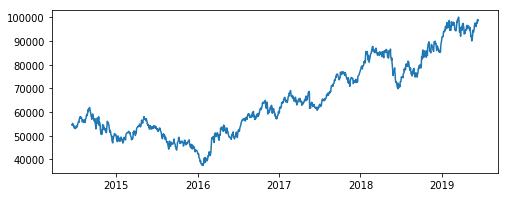

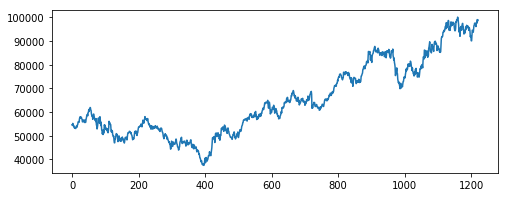

In [69]:
plt.figure(figsize=(8,3))
plt.plot(dfgaps.date, dfgaps.ibvclose)
plt.figure(figsize=(8,3))
plt.plot(dfgaps.ibvclose.values)

In [70]:
dfgaps['gapibv'] = detrend(dfgaps.dayopen - dfgaps.ibvclose) # gap related to ibov index close

In [71]:
dfgaps.head(2)

,gap,result,sign,date,wday,wdayp,phdif,pldif,dayopen,ibvclose,up200,up21,upvl5d,upvl21d,upstd5dhl,upstd21dhl,gapibv
0,302,657,1,2014-06-16,0,4,-30,727,85255,54630.0,1.0,1.0,0.0,0.0,1.0,1.0,4177.761019
1,-47,247,-1,2014-06-17,1,0,650,-363,84659,54300.0,1.0,1.0,0.0,0.0,1.0,1.0,3933.967332


### Target Class 

#### Did it close or not?

In [72]:
dfgaps['gapr'] = 0
dfgaps.loc[ dfgaps.result > 0,  'gapr'] = 1

In [73]:
dfgaps.drop(columns=['result', 'date', 'gapr', 'dayopen', 'ibvclose']).head(4)

,gap,sign,wday,wdayp,phdif,pldif,up200,up21,upvl5d,upvl21d,upstd5dhl,upstd21dhl,gapibv
0,302,1,0,4,-30,727,1.0,1.0,0.0,0.0,1.0,1.0,4177.761019
1,-47,-1,1,0,650,-363,1.0,1.0,0.0,0.0,1.0,1.0,3933.967332
2,145,1,2,1,-976,277,1.0,1.0,1.0,1.0,1.0,1.0,2372.173645
3,-541,-1,4,2,541,-1356,1.0,1.0,0.0,0.0,1.0,1.0,3887.379958


In [74]:
X = dfgaps.drop(columns=['result', 'date', 'gapr', 'dayopen', 'ibvclose'])
y = dfgaps.gapr

In [75]:
len(X)

1221

In [76]:
ixtrain = int(0.7*len(X))
#ixtest = len(X) - ixtrain

In [77]:
from sklearn.ensemble import ExtraTreesClassifier as rfc

In [78]:
classifier = rfc(n_estimators=80) # less estimator better less over-fitting
classifier.fit(X[:ixtrain], y[:ixtrain])

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [79]:
classifier.predict_proba(X[ixtrain:])[:3]

array([[0.    , 1.    ],
       [0.2125, 0.7875],
       [0.2125, 0.7875]])

In [80]:
y[ixtrain:][:3]

858    1
859    1
860    0
Name: gapr, dtype: int64

In [81]:
classifier.score(X[ixtrain:], y[ixtrain:])

0.7329700272479565

In [82]:
dfeatures = pd.DataFrame({'importance' : classifier.feature_importances_, 
              'feature' : 
              dfgaps.drop(columns=['result', 'date', 'gapr', 'dayopen', 'ibvclose']).columns.values.astype(str)})

In [83]:
dfeatures.sort_values(by='importance', ascending=False)

,importance,feature
0,0.234380,gap
12,0.179966,gapibv
5,0.160709,pldif
4,0.154543,phdif
1,0.055343,sign
3,0.053616,wdayp
2,0.053131,wday
7,0.042459,up21
6,0.028424,up200
8,0.012156,upvl5d


####  Features importances for a gap close or not

1. the size of the gap 
2.  - difference in points of the future contract openning and the ibov index close
    - difference in points of the future contract openning and the previous day High
    - difference in points of the future contract openning and the previous day Low     
5. previous day week day position (e. g. monday, tuesday etc.)
6. day week day position (e. g. monday, tuesday etc.)


if the gap sign matters ?? the rest of the table above are useless??

## Conclusion 
### There is no free-lunch

A little  better than simple say roughly 70% of gaps close

In [84]:
# What if we choose only the ones smaller than < 200 points of gap. 
# dfgaps = dfgaps[np.abs(dfgaps.gap) < 230]
# doesnt matter